<a href="https://colab.research.google.com/github/ElisaCastelli/CPAC_CollectiveDynamicPortrait/blob/main/CPACprovaFaceDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer notebook

In [6]:
# explain various libraries
import numpy as np
import PIL

import keras
import tensorflow as tf
import tensorflow_hub as hub

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## variables and style mapping

In [7]:
# path where images are stored
image_folder = 'style_pics/'

# here I should receive parameters from spotify
acousticness = 1
valence = 1

In [8]:
def style_chooser(acousticness, valence):
    if acousticness >= 0.5 and valence >= 0.5 :
        return 'monet_poppy.jpg'
    elif acousticness < 0.5 and valence >= 0.5:
        return 'bosch_garden.jpg'
    elif acousticness >= 0.5 and valence < 0.5 :
        return 'van_gogh_patate.jpg'
    elif acousticness < 0.5 and valence < 0.5 :
        return 'cyberpunk_2077.jpg'
    else:
        return 'error'

In [9]:
style_filename = style_chooser(acousticness, valence)
# insert here the image you want to apply style transfer to
content_filename = 'dummy_photo.jpg'
print('style_filename: ' + style_filename + '\ncontent_filename: ' + content_filename)

style_filename: monet_poppy.jpg
content_filename: dummy_photo.jpg


## functions

In [10]:
# load and rescale an image
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [11]:
# Converts tensor into image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [12]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)
    if title:
        plt.title(title)

### load files

In [13]:
# load images
content_image = load_img(image_folder + content_filename)
style_image = load_img(image_folder + style_filename)

# Fast implementation

### apply fast style transer with pre-trained network from magenta


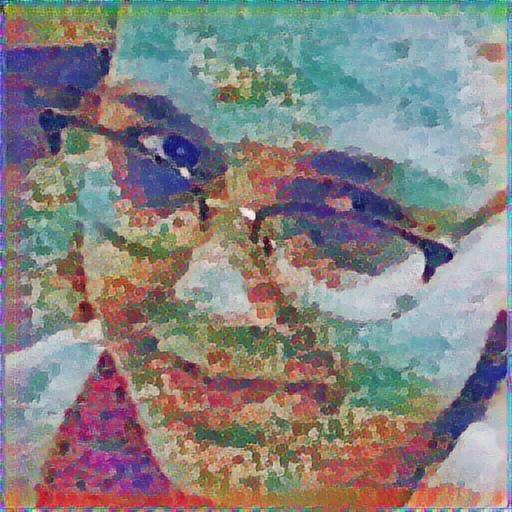

In [14]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
output = tensor_to_image(stylized_image)

output.save(image_folder + 'stylized2' +style_filename) 

tensor_to_image(stylized_image)

# manual implementation

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools  

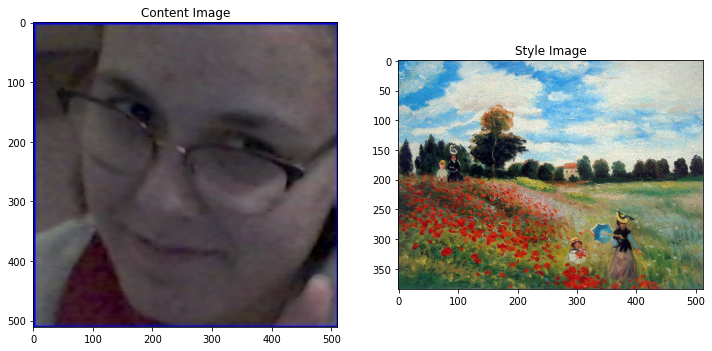

In [16]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [17]:
# Load a VGG19 and test run it on our image to ensure it's used correctly:

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [18]:
# Check Predictions for current image
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('book_jacket', 0.27490884),
 ('electric_ray', 0.049962997),
 ('stingray', 0.036804833),
 ('bathing_cap', 0.036730777),
 ('television', 0.033320516)]

In [19]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [20]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest

#style_layers = ['block1_conv1',
#                'block2_conv1',
#                'block3_conv1', 
#                'block4_conv1', 
#                'block5_conv1']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [21]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # We want to use it as an extractor, so set to false train option
    vgg.trainable = False

    # FILL THE CODE: outputs must be a list containing tensor with the outputs 
    # of each layer contained in layer_names
    # HINT: from a functional model the outputs can be extracted using 
    # model.get_layer(name).output
    outputs = [vgg.get_layer(name).output for name in layer_names]


    # FILL THE CODE Build a functional model that gets vgg.input as input and  
    # outputs the content of each layer contained in layer_names
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [22]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()
    
# Model summary
style_extractor.summary()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  806.1426
  mean:  28.331871

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  3955.4187
  mean:  154.95152

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  8627.206
  mean:  143.61226

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  17790.918
  mean:  620.8784

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  2834.8965
  mean:  41.53754

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_

In [23]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Check
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
    # this is the representation of style

In [24]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [25]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

    print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  15768.274
    mean:  264.00717

Contents:
   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  128569.49
    mean:  5379.9453

Contents:
   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  578649.94
    mean:  7789.7217

Contents:
   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3692406.2
    mean:  123794.164

Contents:
   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  209534.39
    mean:  980.1255

Contents:
   block5_conv2
    shape:  (1, 31, 31, 512)
    min:  0.0
    max:  1645.0664
    mean:  8.563737


In [26]:
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image 
image = tf.Variable(content_image)

# Clip the image
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

# To optimize this, use a weighted combination of the two losses to get the total loss:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# FILL THE CODE: here you will do a custom training loop as explained in the slide
# is a little bit different from the classic training loop since you will be operating
# directly on the image, not on the model, what you need to do is:
# -compute output
# -compute loss
# - compute gradient
# - apply gradient
# - clip the image: image.assign(clip_0_1(image))

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))   


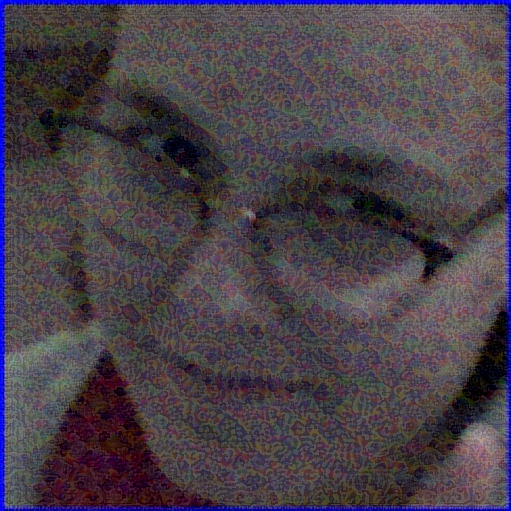

In [27]:

# FILL THE CODE: perform a few training steps
train_step(image)
train_step(image)
train_step(image)
train_step(image)


# Plot the image
tensor_to_image(image)

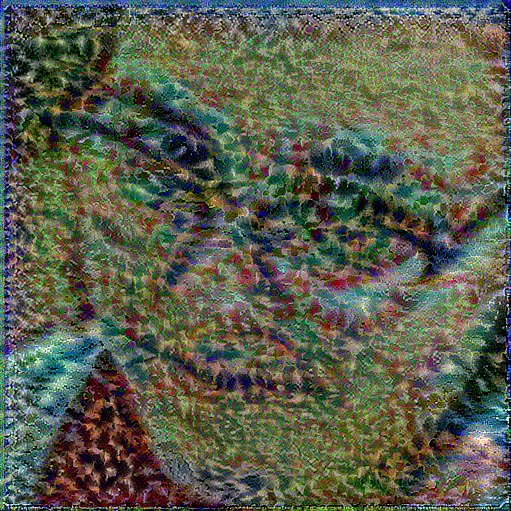

Train step: 100
Total time: 10.8


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [29]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

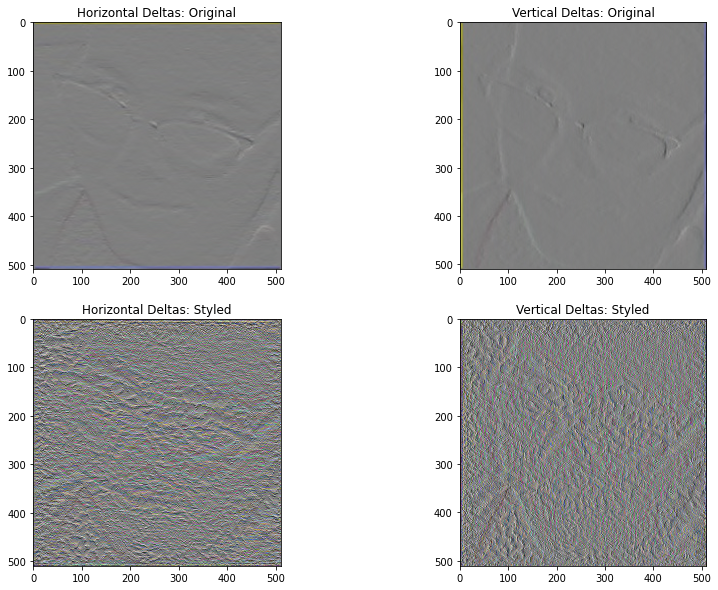

In [30]:

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# Custom
total_variation_loss_custom =total_variation_loss(image).numpy()
# Tensorflow
total_variation_loss =tf.image.total_variation(image).numpy()

print('Total variation loss (custom)',total_variation_loss_custom)
print('Total variation loss',total_variation_loss)

Total variation loss (custom) 167865.78
Total variation loss [167865.78]


In [32]:
# Choose a weight for the total_variation_loss
total_variation_weight=30

# FILL THE CODE: Include it in the train_step function
# Repeat the same custom training loop (tf.GradientTape...) that you did before
# only this take take into account the weighted total_variation loss and sum it
# to the loss

@tf.function()
def train_step(image):
   
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))   

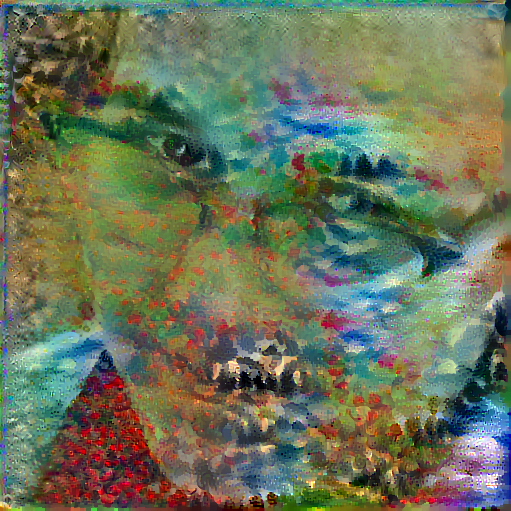

Train step: 1000
Total time: 106.4


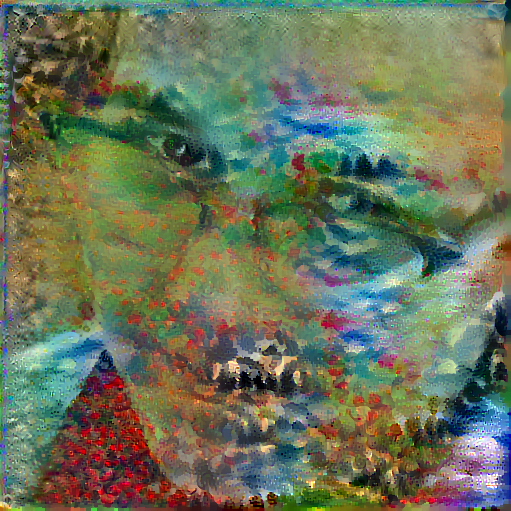

In [33]:
# Re-initialize the optimization variable:
image = tf.Variable(content_image)

# Run the optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  output = tensor_to_image(image)

end = time.time()
print("Total time: {:.1f}".format(end-start))
output

In [34]:
output.save(image_folder + 'manual_stylized' +style_filename)

## free GPU memory (the current kernel will die)

In [35]:
from numba import cuda

cuda.select_device(0)
cuda.close()

In [ ]:
# restart kernel
import os
os._exit(00)